# Phylogenetic Distance Calculation from RhizCG 2013

Notes: Calculate phylogenetic distance using phylogeny created from rbcL and matK in phylogenerator 20160209_phylogeny.tre.  

# Init

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(foreach)
library(lsmeans)
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(phyloseq)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: estimability

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: survival

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: For

In [3]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

## Set file locations

In [4]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'
treeFile = '/home/bryan/RhizCG/PhyDist/20160209_phylogeny.tre'
NAMFile = '/home/bryan/RhizCG/PhyDist/NAM_founders_distanceMatrix_v2.txt'

### Read  tables table 

In [5]:
%%R
setwd(workDir)
# read phylogenetic distance, expanded with 0.0002 between maize
phy_expand = read.csv(file = "phyDist_expanded.csv", header = TRUE)
colnames(phy_expand)[12] = "75-062"

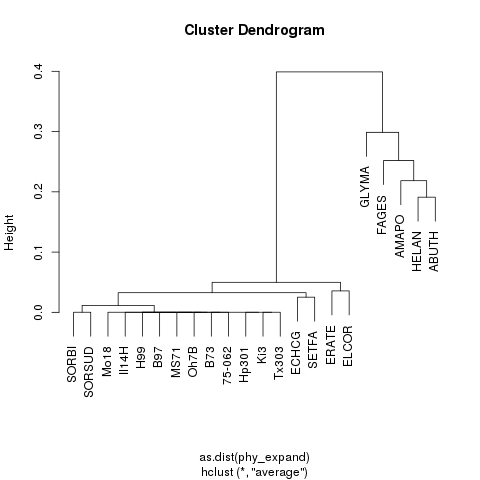

In [6]:
%%R
Phy_hc = hclust(as.dist(phy_expand), "average")
plot(Phy_hc)

In [7]:
%%R 

NAMdist = read.table(NAMFile, header = TRUE)
#reorder so that NAMdist is in same order as log2fold change matrix
NAMdist = NAMdist[c(1:6, 8, 7, 9, 10), c(1:6, 8, 7, 9, 10)]

In [8]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)

physeq.Nneg = subset_samples(physeq.Full, Treatment == "Nneg" & Plant != "BARE")
physeq.Nneg = filter_taxa(physeq.Nneg, function(x) sum(x > 0) > 0, TRUE)  
physeq.Nneg

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4927 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4927 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4927 tips and 4926 internal nodes ]


## Define subset of plants for model comparison

In [9]:
%%R
# phy = subset_samples(physeq.Nneg, Plant %in% c("AMAPO", "GLYMA",  "ERATE", 
#  "ELCOR",  "SORSUD",    "SORBI",  "ABUTH",  "HELAN",  "ECHCG", "SETFA", "MS71", "Mo18"))

phy = physeq.Nneg

phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4927 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4927 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4927 tips and 4926 internal nodes ]


## Calculate w-Unifrac distances

In [10]:
%%R
registerDoParallel(cores=28)
phy.wunif.dist = distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

## Create melted dataframes for plot by plot comparisons

In [11]:
%%R
pd.m = melt(as.matrix(phy_expand))

#set column names and create comparison column
colnames(pd.m) = c("PlantA", "PlantB", "phy_Dist")
pd.m$PlantComp = paste(pd.m$PlantA, pd.m$PlantB, sep = "-")
pd.m %>% head


  PlantA PlantB phy_Dist   PlantComp
1  FAGES  FAGES  0.00000 FAGES-FAGES
2  AMAPO  FAGES  0.23210 AMAPO-FAGES
3  HELAN  FAGES  0.25302 HELAN-FAGES
4  ABUTH  FAGES  0.27096 ABUTH-FAGES
5  GLYMA  FAGES  0.35879 GLYMA-FAGES
6  SORBI  FAGES  0.43476 SORBI-FAGES


In [12]:
%%R
ud = as.matrix(phy.wunif.dist) 
# remove lower triangle to remove duplicate values
ud[ lower.tri( ud, diag = TRUE ) ]  <- NA
head(ud)
ud.m = melt(ud, na.rm= TRUE)
colnames(ud.m) = c("PlotA", "PlotB", "w_Unif_Dist")
head(ud.m) %>% print
dim(ud.m) %>% print

                PlotA             PlotB w_Unif_Dist
88  sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072
175 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861
176 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471
262 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018
263 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794
264 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279
[1] 3741    3


## Create functional distance variable (on raw data)

In [13]:
%%R
#add growing degree days
DAP = c(36, 53, 57, 61, 72, 79, 84, 88)
GDD = c(795.1, 1089.4, 1136.8, 1199.5, 1394.3, 1512.4, 1573.8, 1625.6)
M_GDD = cbind(DAP, GDD) %>% as.data.frame
M_GDD

# add seed size
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric
(SS)

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
    Plant SeedSize_mg
1   ERATE      0.0035
2   HELAN     90.0000
3     B73    333.0000
4   FAGES     38.0000
5   AMAPO      0.4900
6  SORSUD     10.7000
7   SORBI     32.3900
8   ELCOR      3.2000
9   ECHCG      1.5800
10  ABUTH      9.6000
11  SETFA      1.8000
12  GLYMA    174.0000
13   MS71      0.2640
14   Mo18      0.2240
15  Il14H      0.2190
16  Tx303      0.2790
17   Oh7B      0.2070
18    B97      0.2400
19  Hp301      0.0869
20 75-062      0.2220
21    Ki3      0.2280
22    H99      0.2310


In [16]:
%%R
sd = as(sample_data(phy), "data.frame")
sd$Plant %>% levels %>% print
sd = left_join(sd, SS, by = "Plant")
sd = left_join(sd, M_GDD, by = "DAP")
colnames(sd)

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 
 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "

Importance of components:
                         PC1    PC2    PC3    PC4     PC5
Standard deviation     1.799 1.0536 0.7285 0.3521 0.02267
Proportion of Variance 0.647 0.2220 0.1062 0.0248 0.00010
Cumulative Proportion  0.647 0.8689 0.9751 0.9999 1.00000
                         PC1        PC2         PC3        PC4          PC5
DAP               0.52518268 -0.1162307  0.10756008 -0.8360261 -0.012835730
log(SeedSize_mg) -0.07219738  0.8915590  0.43241518 -0.1136908  0.001231492
log(tN_p)         0.45510505  0.3477658 -0.60265278  0.1518015  0.534513101
log(Plant_CN)     0.46327099 -0.2292752  0.65450019  0.4012889  0.378694622
log(Biomass_P)    0.54518812  0.1345537 -0.09943372  0.3225807 -0.755460029


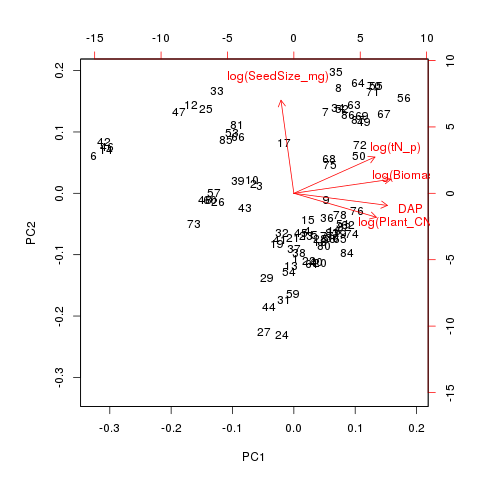

In [18]:
%%R
# PCA of annuals

 fit = prcomp(~DAP + log(SeedSize_mg) + log(tN_p) + log(Plant_CN) + log(SeedSize_mg) + log(Biomass_P), data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

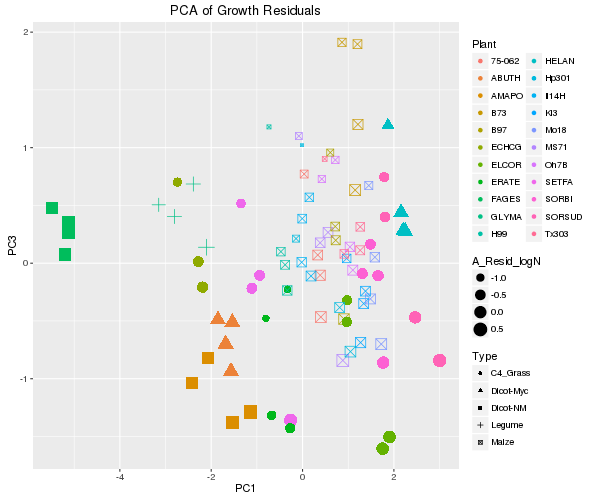

In [20]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sd, S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(phy) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC3, colour = Plant, 
                       size = A_Resid_logN, pch = Type))
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

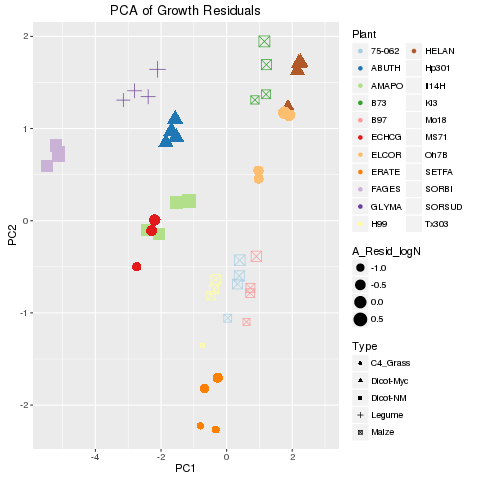

In [21]:
%%R
p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN, pch = Type))
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [22]:
%%R
#measure distances on PC1
sd = sample_data(phy)
PC1dist = dist(sd[, "PC1"], method = "euclidian")
    #melt matrix
    PC1.m = melt(as.matrix(PC1dist))

    #set column names and create comparison column
     colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
    PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
    PC1.m %>% head

#measure distances on PC2
PC2dist = dist(sd[,"PC2"], method = "euclidian")
    #melt matrix
    PC2.m = melt(as.matrix(PC2dist))

    #set column names and create comparison column
     colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
    PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
    PC2.m %>% head

#measure distances on PC3
PC3dist = dist(sd[,"PC3"], method = "euclidian")
    #melt matrix
    PC3.m = melt(as.matrix(PC3dist))

    #set column names and create comparison column
     colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
    PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
    PC3.m %>% head %>% print

#measure distances on residCN
CNdist = dist(sd[,"A_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Bdist = dist(sd[,"A_Resid_logB"], method = "euclidian")
    #melt matrix
    B.m = melt(as.matrix(Bdist))

    #set column names and create comparison column
     colnames(B.m) = c("PlotA", "PlotB", "Bdist")
    B.m$PlotComp = paste(B.m$PlotA, B.m$PlotB, sep = "-")
    B.m %>% head %>% print

Fundist = dist(sd[,c("PC1", "PC2", "PC3")], method = "euclidian")
    Fun.m = melt(as.matrix(Fundist))

    #set column names and create comparison column
     colnames(Fun.m) = c("PlotA", "PlotB", "FunDist")
    Fun.m$PlotComp = paste(Fun.m$PlotA, PC3.m$PlotB, sep = "-")
    Fun.m %>% head %>% print
PCA.m = left_join(PC1.m, PC2.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, PC3.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, Fun.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, CN.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, B.m[,c(3,4)], by = "PlotComp")
head(PCA.m)

              PlotA             PlotB   PC3Dist
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.0000000
2 sample4-2.02_Nneg sample5-1.22_Nneg 0.9883645
3 sample4-4.21_Nneg sample5-1.22_Nneg 0.8767810
4 sample5-2.29_Nneg sample5-1.22_Nneg 0.8757294
5 sample5-2.06_Nneg sample5-1.22_Nneg 0.5051915
6 sample1-2.23_Nneg sample5-1.22_Nneg 0.2967312
                             PlotComp
1 sample5-1.22_Nneg-sample5-1.22_Nneg
2 sample4-2.02_Nneg-sample5-1.22_Nneg
3 sample4-4.21_Nneg-sample5-1.22_Nneg
4 sample5-2.29_Nneg-sample5-1.22_Nneg
5 sample5-2.06_Nneg-sample5-1.22_Nneg
6 sample1-2.23_Nneg-sample5-1.22_Nneg
              PlotA             PlotB     CNdist
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.00000000
2 sample4-2.02_Nneg sample5-1.22_Nneg 0.39380360
3 sample4-4.21_Nneg sample5-1.22_Nneg 0.30193239
4 sample5-2.29_Nneg sample5-1.22_Nneg 0.21610061
5 sample5-2.06_Nneg sample5-1.22_Nneg 0.03917953
6 sample1-2.23_Nneg sample5-1.22_Nneg 0.66441421
                             PlotComp
1 sample5-1.22_Nn

## Join distance tables

In [23]:
%%R
#Join with plant names
ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotA" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[4] = "PlantA"

ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotB" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[5] = "PlantB"
ud.m$PlantComp = paste(ud.m$PlantA, ud.m$PlantB, sep = "-")

#Create plot comparison for joining with functional distance matrix
ud.m$PlotComp = paste(ud.m$PlotA, ud.m$PlotB, sep = "-")
head(ud.m) %>% print

              PlotA             PlotB w_Unif_Dist  Plant
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062
2 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861 75-062
3 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA
4 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018 75-062
5 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794  SETFA
6 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279  SETFA
              PlotA             PlotB w_Unif_Dist PlantA  Plant
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062  SETFA
2 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861 75-062  SETFA
3 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA  SETFA
4 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018 75-062 75-062
5 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794  SETFA 75-062
6 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279  SETFA 75-062
              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062  SETFA  75-062-SET

## Join with plant phylogenetic distance and functional distance

In [24]:
%%R
Dist = left_join(ud.m, pd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

#Join with 
# Join DAP information and library information
Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotA" = "X.sample"))
colnames(Dist)[9:10] = c("LibraryA","DAY_A")
tail(Dist) %>% print

Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotB" = "X.sample"))
colnames(Dist)[11:12] = c("LibraryB","DAY_B")
tail(Dist) %>% print

Dist = left_join(Dist, PCA.m[,3:9], by = "PlotComp")

# set DAY_A and DAY_B as factor
Dist$DAY_A = as.factor(Dist$DAY_A)
Dist$DAY_B = as.factor(Dist$DAY_B)
Dist$TimeDist = abs(as.numeric(as.character(Dist$DAY_A)) - as.numeric(as.character(Dist$DAY_B)))

#create factor for cross library comps and same day comps
Dist$LibraryComp = ifelse(Dist$LibraryA == Dist$LibraryB, 0, 1) %>% as.factor
Dist$SameDay = ifelse(Dist$DAY_A == Dist$DAY_B, 0, 1) %>% as.factor

head(Dist)

                 PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
3736 sample3-2.19_Nneg sample8-3.03_Nneg   0.2419601  ABUTH  ELCOR ABUTH-ELCOR
3737 sample8-1.23_Nneg sample8-3.03_Nneg   0.1984166    Ki3  ELCOR   Ki3-ELCOR
3738 sample6-2.14_Nneg sample8-3.03_Nneg   0.2503097  Hp301  ELCOR Hp301-ELCOR
3739 sample8-4.04_Nneg sample8-3.03_Nneg   0.2377478   Mo18  ELCOR  Mo18-ELCOR
3740 sample3-3.30_Nneg sample8-3.03_Nneg   0.2233484  ABUTH  ELCOR ABUTH-ELCOR
3741 sample7-4.14_Nneg sample8-3.03_Nneg   0.2893173  SORBI  ELCOR SORBI-ELCOR
                                PlotComp phy_Dist
3736 sample3-2.19_Nneg-sample8-3.03_Nneg  0.36639
3737 sample8-1.23_Nneg-sample8-3.03_Nneg  0.05090
3738 sample6-2.14_Nneg-sample8-3.03_Nneg  0.05090
3739 sample8-4.04_Nneg-sample8-3.03_Nneg  0.05090
3740 sample3-3.30_Nneg-sample8-3.03_Nneg  0.36639
3741 sample7-4.14_Nneg-sample8-3.03_Nneg  0.04779
                 PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
3736 sample3-2.19_

# Build corMLPE models

## corMLPE models without random effects

In [25]:
%%R
str(Dist)

'data.frame':	3741 obs. of  21 variables:
 $ PlotA      : chr  "sample5-1.22_Nneg" "sample5-1.22_Nneg" "sample4-2.02_Nneg" "sample5-1.22_Nneg" ...
 $ PlotB      : chr  "sample4-2.02_Nneg" "sample4-4.21_Nneg" "sample4-4.21_Nneg" "sample5-2.29_Nneg" ...
 $ w_Unif_Dist: num  0.207 0.161 0.185 0.151 0.188 ...
 $ PlantA     : Factor w/ 22 levels "75-062","ABUTH",..: 1 1 19 1 19 19 1 19 19 1 ...
 $ PlantB     : Factor w/ 22 levels "75-062","ABUTH",..: 19 19 19 1 1 1 17 17 17 17 ...
 $ PlantComp  : chr  "75-062-SETFA" "75-062-SETFA" "SETFA-SETFA" "75-062-75-062" ...
 $ PlotComp   : chr  "sample5-1.22_Nneg-sample4-2.02_Nneg" "sample5-1.22_Nneg-sample4-4.21_Nneg" "sample4-2.02_Nneg-sample4-4.21_Nneg" "sample5-1.22_Nneg-sample5-2.29_Nneg" ...
 $ phy_Dist   : num  0.0311 0.0311 0 0 0.0311 ...
 $ LibraryA   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_A      : Factor w/ 8 levels "36","53","57",..: 5 5 4 5 4 4 5 4 4 5 ...
 $ LibraryB   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_B      : Factor w/ 8 levels "36"

In [26]:
%%R
#Base models
fit1 =  gls(w_Unif_Dist ~ 1, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
Z <- corZ(fit1) #extract correlation structure from previous fit

In [27]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: Dist 
        AIC       BIC   logLik
  -11783.89 -11765.21 5894.943

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2574348 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.2503534 0.00751048 33.33388       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.2180940 -0.7392044 -0.1107053  0.6166584  4.4016003 

Residual standard error: 0.06865901 
Degrees of freedom: 3741 total; 3740 residual


In [28]:
%%R
#Controlling for time and batch effects, using same correlation structure
fit2 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)



In [29]:
%%R
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: Dist 
        AIC       BIC   logLik
  -12384.39 -12347.04 6198.196

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2713269 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.20907319 0.007491263 27.908937       0
TimeDist     0.00125187 0.000090928 13.767600       0
SameDay1     0.02002566 0.002488400  8.047607       0
LibraryComp1 0.01071976 0.001546897  6.929847       0

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist     -0.030              
SameDay1     -0.175 -0.480       
LibraryComp1 -0.019 -0.164 -0.192

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3629892 -0.7375196 -0.1300983  0.5913388  4.3035740 

Residual standard error: 0.06481681 
Degrees of freedom: 3741 total; 3737 residual


### Remove above fit 3

In [ ]:
%%R
#Hypothesis testing functional distance
fit3 =  gls(w_Unif_Dist ~ SameDay + LibraryComp + PC1dist + PC2dist + PC3dist, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)


In [41]:
%%R
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + LibraryComp + PC1dist + PC2dist + PC3dist 
  Data: Dist 
        AIC       BIC   logLik
  -12175.68 -12125.87 6095.839

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.267687 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.21177301 0.007756525 27.302563  0.0000
SameDay1      0.03648719 0.002238916 16.296806  0.0000
LibraryComp1  0.01424464 0.001570420  9.070593  0.0000
PC1dist       0.00021639 0.000501058  0.431865  0.6659
PC2dist       0.00034943 0.000872710  0.400393  0.6889
PC3dist      -0.00053721 0.001273736 -0.421761  0.6732

 Correlation: 
             (Intr) SamDy1 LbrrC1 PC1dst PC2dst
SameDay1     -0.210                            
LibraryComp1 -0.033 -0.313                     
PC1dist      -0.125 -0.010  0.079              
PC2dist      -0.102 -0.004 -0.034 -0.114       
PC3dist      -0.127 -0.018  0.024  0.071 -0.112

Sta

In [ ]:
%%R
#H2: phylogenetic dist
fit4 =  gls(w_Unif_Dist ~ TimeDist + phy_Dist + SameDay + LibraryComp, 
            correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)


In [42]:
%%R
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + phy_Dist + SameDay + LibraryComp 
  Data: Dist 
        AIC       BIC   logLik
  -12381.33 -12337.75 6197.665

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2657677 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.20725521 0.007367031 28.132799  0.0000
TimeDist     0.00115488 0.000098034 11.780471  0.0000
phy_Dist     0.02028344 0.007713622  2.629561  0.0086
SameDay1     0.01961004 0.002492782  7.866729  0.0000
LibraryComp1 0.01130321 0.001562220  7.235348  0.0000

 Correlation: 
             (Intr) TimDst phy_Ds SamDy1
TimeDist      0.007                     
phy_Dist     -0.094 -0.375              
SameDay1     -0.171 -0.420 -0.065       
LibraryComp1 -0.032 -0.204  0.142 -0.199

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3353820 -0.7334692 -0.1418976  0.6091997  4.3350586 

Residual standar

In [ ]:
%%R
fit5 =  gls(w_Unif_Dist ~ TimeDist + poly(phy_Dist,2) + SameDay + LibraryComp, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)


In [43]:
%%R
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + poly(phy_Dist, 2) + SameDay + LibraryComp 
  Data: Dist 
        AIC       BIC   logLik
  -12502.55 -12452.74 6259.274

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.251658 

Coefficients:
                        Value  Std.Error    t-value p-value
(Intercept)         0.2138670 0.00688716  31.053022       0
TimeDist            0.0011882 0.00009657  12.303690       0
poly(phy_Dist, 2)1  0.6905093 0.09452695   7.304893       0
poly(phy_Dist, 2)2 -0.8580106 0.07699514 -11.143698       0
SameDay1            0.0154438 0.00248397   6.217391       0
LibraryComp1        0.0108511 0.00153963   7.047826       0

 Correlation: 
                   (Intr) TimDst p(_D,2)1 p(_D,2)2 SamDy1
TimeDist           -0.060                                
poly(phy_Dist, 2)1  0.093 -0.324                         
poly(phy_Dist, 2)2 -0.042 -0.035 -0.432                  
SameDay1           -0.19

In [ ]:
%%R
#H3: combined phylogenetic distance and functional
fit6=  gls(w_Unif_Dist ~ SameDay + LibraryComp + PC1dist + PC2dist + PC3dist + phy_Dist, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)


In [44]:
%%R
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + LibraryComp + PC1dist + PC2dist + PC3dist +      phy_Dist 
  Data: Dist 
       AIC       BIC   logLik
  -12221.4 -12165.38 6119.701

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2507272 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20608712 0.007301172 28.226580  0.0000
SameDay1      0.03191244 0.002307899 13.827486  0.0000
LibraryComp1  0.01509271 0.001565359  9.641693  0.0000
PC1dist       0.00020136 0.000497990  0.404349  0.6860
PC2dist       0.00029801 0.000867606  0.343486  0.7313
PC3dist      -0.00028928 0.001266521 -0.228406  0.8193
phy_Dist      0.05488450 0.007274573  7.544704  0.0000

 Correlation: 
             (Intr) SamDy1 LbrrC1 PC1dst PC2dst PC3dst
SameDay1     -0.186                                   
LibraryComp1 -0.042 -0.320                            
PC1dist      -0.131 -0.009  0.078                     
P

In [45]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

     Model df       AIC       BIC   logLik   Test  L.Ratio p-value
fit1     1  3 -11783.89 -11765.20 5894.943                        
fit2     2  6 -12384.39 -12347.04 6198.196 1 vs 2 606.5071  <.0001
fit3     3  8 -12175.68 -12125.88 6095.839 2 vs 3 204.7138  <.0001
fit4     4  7 -12381.33 -12337.75 6197.665 3 vs 4 203.6503  <.0001
fit5     5  8 -12502.55 -12452.74 6259.274 4 vs 5 123.2179  <.0001
fit6     6  9 -12221.40 -12165.38 6119.701 5 vs 6 279.1444  <.0001


Notes: Phylogenetic distance^2 and time make the best model on the overall dataset of annuals plus B73

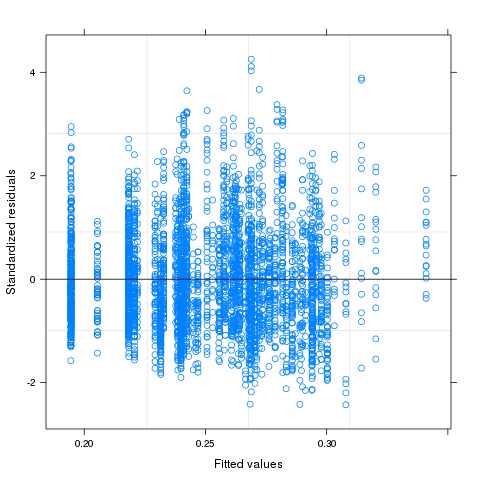

In [46]:
%%R
plot(fit5)

In [60]:
%%R
#test <- function(x) {-.858x^2 + .69x  + .206}

data = Dist #filter(Dist, PlantA == "ECHCG")
                  
p = ggplot(data, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point() #aes(size = phy_Dist), shape = 1)
p = p + stat_smooth(method = "lm", y ~ -.858x^2 + .69x  + .206, se = FALSE)
## p = p + theme_bw(base_size = 16)
# p = p + ggtitle("Phylogenetic distance vs Microbial Community Dissimilarity ")
# p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
#p = p + stat_function(fun = test)
p



Error while parsing the string.


### Not used, but if date/combo is random effect:

In [62]:
%%R
Dist$DateCombo = ifelse(as.numeric(as.character(Dist$DAY_A)) < as.numeric(as.character(Dist$DAY_B)),
                                                                    paste(Dist$DAY_A, Dist$DAY_B, sep = "-"), 
                                                                   paste(Dist$DAY_B, Dist$DAY_A, sep = "-"))
Dist$DateCombo %>% unique


 [1] "61-72" "61-61" "72-72" "36-72" "36-61" "72-79" "61-79" "36-79" "79-79"
[10] "53-72" "53-61" "36-53" "53-79" "57-72" "57-61" "36-57" "57-79" "53-57"
[19] "36-36" "57-57" "53-53" "72-88" "61-88" "36-88" "79-88" "53-88" "57-88"
[28] "72-84" "61-84" "36-84" "79-84" "53-84" "57-84" "84-88" "88-88" "84-84"


In [ ]:
%%R


fit10 <- lme(w_Unif_Dist ~ 1, random =~ 1|DateCombo, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit10) %>% print


In [ ]:
%%R
fit11 <- lme(w_Unif_Dist ~ phy_Dist, random =~ 1|DateCombo, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)

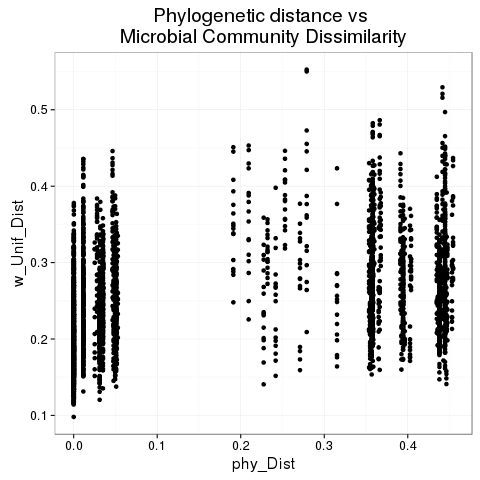

In [190]:
%%R
#test <- function(x) {-.69*x ^ 2 + .858*x + .213}

                  
p = ggplot(Dist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~poly(x,2), se = FALSE)
p = p + theme_bw(base_size = 16)
p = p + ggtitle("Phylogenetic distance vs \n Microbial Community Dissimilarity ")
#p = p + stat_function(fun = test)
p

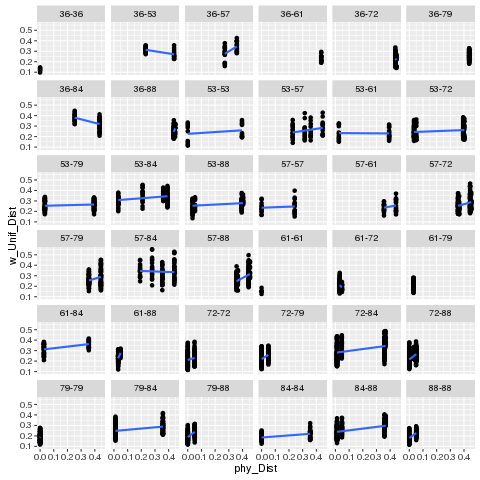

In [63]:
%%R

p = ggplot(Dist, aes(x = phy_Dist, y = w_Unif_Dist))
           p = p + geom_point()
        p = p + stat_smooth(method = "lm", se = FALSE)
           p = p + facet_wrap(~DateCombo)
           p

# GLS model on early subset of plants

In [64]:
%%R
Dist$DAY_A %>% unique

[1] 72 61 36 79 53 57 88 84
Levels: 36 53 57 61 72 79 84 88


In [65]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, DAY_A %in% c( "53", "57", "61") & DAY_B %in% c( "53", "57", "61"))


dim(SubDist) %>% print
SubDist$PlantA %>% unique

[1] 3741   22
[1] 171  22
[1] SETFA AMAPO GLYMA ABUTH ECHCG
Levels: ABUTH AMAPO ECHCG GLYMA SETFA


In [66]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)


In [67]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: SubDist 
        AIC       BIC   logLik
  -572.9469 -563.5395 289.4734

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3437059 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.2442186 0.01806515 13.51877       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9596585 -0.6918894 -0.1685355  0.7146741  2.7786870 

Residual standard error: 0.06632499 
Degrees of freedom: 171 total; 170 residual


In [68]:
%%R
fit2=  gls(w_Unif_Dist ~ SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay 
  Data: SubDist 
        AIC       BIC   logLik
  -578.4524 -565.9328 293.2262

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3583939 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.22766022 0.018828099 12.091513   0e+00
SameDay1    0.02440937 0.005966594  4.091005   1e-04

 Correlation: 
         (Intr)
SameDay1 -0.215

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7127356 -0.7151168 -0.1873108  0.6716921  2.6645671 

Residual standard error: 0.06621917 
Degrees of freedom: 171 total; 169 residual


In [69]:
%%R
fit3=  gls(w_Unif_Dist ~ SameDay + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -581.8775 -566.2577 295.9388

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3628187 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.21763188 0.018820106 11.563797  0.0000
SameDay1    0.01226746 0.006772043  1.811485  0.0719
phy_Dist    0.06743478 0.019637176  3.434037  0.0007

 Correlation: 
         (Intr) SamDy1
SameDay1 -0.096       
phy_Dist -0.155 -0.523

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6061678 -0.7523369 -0.1661927  0.6663387  2.6465692 

Residual standard error: 0.06508475 
Degrees of freedom: 171 total; 168 residual


In [70]:
%%R
fit4=  gls(w_Unif_Dist ~  SameDay + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + poly(phy_Dist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -577.5192 -558.8113 294.7596

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3631226 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)        0.23522773 0.01881830 12.499947  0.0000
SameDay1           0.01325381 0.00691106  1.917769  0.0568
poly(phy_Dist, 2)1 0.13798554 0.04058196  3.400170  0.0008
poly(phy_Dist, 2)2 0.03339920 0.04538935  0.735838  0.4629

 Correlation: 
                   (Intr) SamDy1 p(_D,2)1
SameDay1           -0.249                
poly(phy_Dist, 2)1  0.130 -0.520         
poly(phy_Dist, 2)2 -0.048  0.194 -0.037  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6123310 -0.7762844 -0.1505322  0.6749722  2.6734668 

Residual standard error: 0.06523585 
Degrees of freedom: 171 total; 167 residual


In [71]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ SameDay + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + PC1Dist + PC2Dist + PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -549.1676 -527.3837 281.5838

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3591863 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.22103833 0.020048819 11.025005  0.0000
SameDay1     0.02384077 0.008488557  2.808577  0.0056
PC1Dist      0.00547557 0.006635981  0.825133  0.4105
PC2Dist     -0.00039938 0.007904685 -0.050525  0.9598
PC3Dist      0.00329541 0.005753876  0.572728  0.5676

 Correlation: 
         (Intr) SamDy1 PC1Dst PC2Dst
SameDay1 -0.037                     
PC1Dist  -0.199 -0.223              
PC2Dist  -0.122 -0.696  0.133       
PC3Dist  -0.177  0.091 -0.231 -0.074

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6971505 -0.7256816 -0.2138755  0.6996350  2.6801461 

Residual standard error: 0.06671295 
De

In [72]:
%%R
fit6=  gls(w_Unif_Dist ~  SameDay + phy_Dist + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + phy_Dist + PC1Dist + PC2Dist + PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -552.8462 -527.9987 284.4231

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
    Rho 
0.36345 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.21639902 0.019774481 10.943347  0.0000
SameDay1     0.01467480 0.008628396  1.700756  0.0909
phy_Dist     0.07285046 0.021105828  3.451675  0.0007
PC1Dist      0.00570062 0.006419189  0.888060  0.3758
PC2Dist     -0.00600993 0.007815608 -0.768965  0.4430
PC3Dist     -0.00246343 0.005807460 -0.424184  0.6720

 Correlation: 
         (Intr) SamDy1 phy_Ds PC1Dst PC2Dst
SameDay1 -0.013                            
phy_Dist -0.067 -0.308                     
PC1Dist  -0.195 -0.215  0.009              
PC2Dist  -0.103 -0.583 -0.208  0.128       
PC3Dist  -0.147  0.171 -0.287 -0.223 -0.009

Standardized residuals:
       Min  

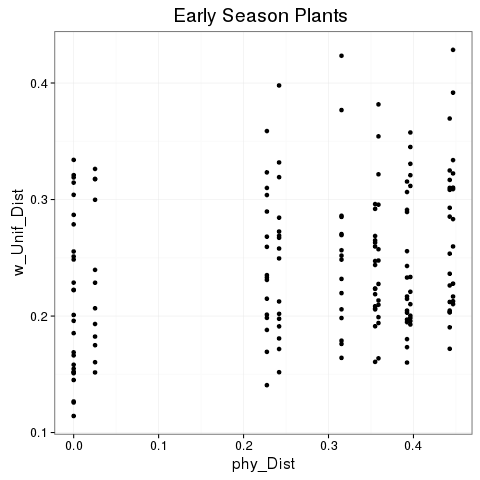

In [74]:
%%R
p1 = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p1 = p1 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p1 = p1 + theme_bw(base_size = 16)
p1 = p1 + ggtitle("Early Season Plants ")
#p = p + stat_function(fun = test)
p1

# Subset of late season plants

In [75]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, PlantA %in% c("MS71",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN",    "Mo18") & PlantB %in% c("MS71", "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI",  "HELAN",  "Mo18"))
dim(SubDist) %>% print
SubDist$PlantA %>% unique

[1] 3741   22
[1] 378  22
[1] MS71   ERATE  ELCOR  SORSUD SORBI  HELAN  Mo18  
Levels: ELCOR ERATE HELAN Mo18 MS71 SORBI SORSUD


In [76]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [77]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: SubDist 
        AIC       BIC   logLik
  -1015.341 -1003.544 510.6706

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.1980253 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.2548243 0.01271318 20.04412       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.8929558 -0.7726435 -0.1220717  0.5227848  3.1488925 

Residual standard error: 0.07353809 
Degrees of freedom: 378 total; 377 residual


In [78]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: SubDist 
        AIC       BIC   logLik
  -1188.294 -1164.749 600.1472

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2638468 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20726152 0.012748842 16.257281       0
TimeDist     -0.01329776 0.002075906 -6.405760       0
SameDay1      0.10693579 0.009681678 11.045171       0
LibraryComp1  0.15403404 0.021865247  7.044697       0

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist     -0.029              
SameDay1     -0.099 -0.753       
LibraryComp1  0.022 -0.945  0.572

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.50747903 -0.71429885 -0.07986169  0.62268468  2.84825648 

Residual standard error: 0.06239944 
Degrees of freedom: 378 total; 374 residual


In [79]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -1226.818 -1199.367 620.4089

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2644966 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.19111878 0.012249524 15.602139       0
TimeDist     -0.01149179 0.001971390 -5.829283       0
SameDay1      0.09274108 0.009337957  9.931624       0
LibraryComp1  0.13963786 0.020688458  6.749554       0
phy_Dist      0.17609305 0.025188587  6.990986       0

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist     -0.053                     
SameDay1     -0.054 -0.757              
LibraryComp1  0.040 -0.945  0.577       
phy_Dist     -0.189  0.131 -0.217 -0.100

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3838200 -0.6726156 -0.0429087  0.6623326  2.5876450 

Residua

In [80]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) 
  Data: SubDist 
        AIC       BIC   logLik
  -1251.894 -1220.543 633.9469

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2426109 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.2129254 0.01078911 19.735226       0
TimeDist           -0.0119258 0.00190638 -6.255750       0
SameDay1            0.0917000 0.00903601 10.148294       0
LibraryComp1        0.1430795 0.01997977  7.161221       0
poly(phy_Dist, 2)1  0.4111046 0.07029596  5.848196       0
poly(phy_Dist, 2)2 -0.2610320 0.04708820 -5.543470       0

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1
TimeDist           -0.027                              
SameDay1           -0.115 -0.756                       
LibraryComp1        0.020 -0.946  0.577                
poly(phy_Dist, 2)1  0.034  0.

In [82]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ SameDay + LibraryComp  + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + LibraryComp + PC1Dist + PC2Dist + PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -1214.673 -1183.322 615.3365

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2392603 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.16176739 0.012041680 13.433955  0.0000
SameDay1      0.04832193 0.006426329  7.519368  0.0000
LibraryComp1 -0.02384909 0.008912773 -2.675833  0.0078
PC1Dist       0.04180594 0.005929246  7.050802  0.0000
PC2Dist       0.00394323 0.003198884  1.232690  0.2185
PC3Dist       0.02160998 0.004361998  4.954148  0.0000

 Correlation: 
             (Intr) SamDy1 LbrrC1 PC1Dst PC2Dst
SameDay1     -0.096                            
LibraryComp1  0.118 -0.400                     
PC1Dist      -0.177  0.022 -0.610              
PC2Dist      -0.080 -0.314  0.059 -0.439       
PC3Dist      -0.313 -0.092  0.059 -0.019  0.056

In [83]:
%%R
fit6=  gls(w_Unif_Dist ~ SameDay + LibraryComp + poly(phy_Dist,2)  + PC1Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + LibraryComp + poly(phy_Dist, 2) + PC1Dist +      PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -1265.269 -1230.024 641.6347

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2168599 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.1766307 0.01071497 16.484481  0.0000
SameDay1            0.0440002 0.00580218  7.583389  0.0000
LibraryComp1       -0.0137549 0.00848035 -1.621974  0.1057
poly(phy_Dist, 2)1  0.3490800 0.06863675  5.085905  0.0000
poly(phy_Dist, 2)2 -0.2087439 0.04611793 -4.526306  0.0000
PC1Dist             0.0366745 0.00510353  7.186104  0.0000
PC3Dist             0.0161531 0.00413868  3.902945  0.0001

 Correlation: 
                   (Intr) SamDy1 LbrrC1 p(_D,2)1 p(_D,2)2 PC1Dst
SameDay1           -0.162                                       
LibraryComp1        0.158 -0.421                       

In [84]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

     Model df       AIC       BIC   logLik   Test   L.Ratio p-value
fit1     1  3 -1015.341 -1003.544 510.6706                         
fit2     2  6 -1188.294 -1164.749 600.1472 1 vs 2 178.95325  <.0001
fit3     3  7 -1226.818 -1199.367 620.4089 2 vs 3  40.52338  <.0001
fit4     4  8 -1251.894 -1220.543 633.9469 3 vs 4  27.07596  <.0001
fit5     5  8 -1214.673 -1183.322 615.3365                         
fit6     6  9 -1265.269 -1230.024 641.6347 5 vs 6  52.59633  <.0001


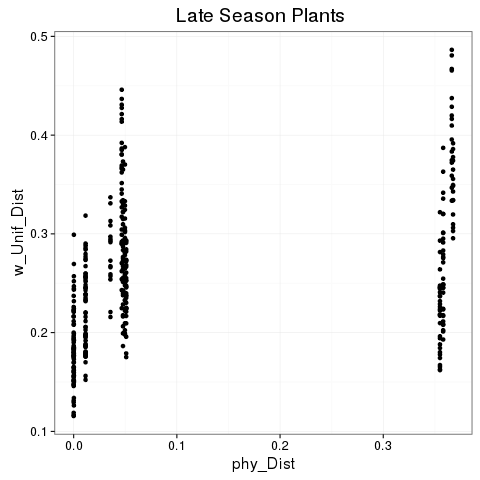

In [196]:
%%R
p2 = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p2 = p2 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p2 = p2 + theme_bw(base_size = 16)
p2 = p2 + ggtitle("Late Season Plants ")
#p = p + stat_function(fun = test)
p2

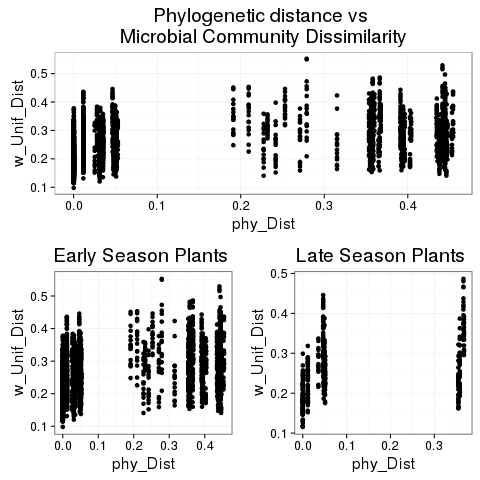

In [199]:
%%R
 grid.arrange(p,p1,p2, layout_matrix = rbind(c(1,1), c(2,3)))